Get Data


In [ ]:
import torch
from torch import nn

In [ ]:
torch.__version__

'2.8.0+cu126'

In [ ]:
torch.cuda.is_available()   # If ut's True then we have GPU and if it's False then we don't have GPU

True

In [ ]:
import requests
import zipfile
from pathlib import Path
import os

# Setup data path
data_path= Path("data/")
image_path= data_path / "food_images"

# If te image folder doesn't exist then download it
if image_path.is_dir():
  print(f"{image_path} directory already exists skipping download")
else:
  print(f"{image_path} doesn't exist creating one")
  image_path.mkdir(parents= True, exist_ok= True)

# Download the zip file
with open(data_path / "food_images.zip", "wb") as f:
  request= requests.get("https://programmingoceanacademy.s3.ap-southeast-1.amazonaws.com/image_classification_dataset.zip")
  print("Downloading the Data..")
  f.write(request.content)

# Unzip the data
with zipfile.ZipFile(data_path / "food_images.zip", "r") as zip_ref:
  print("unzipping the files")
  zip_ref.extractall(image_path)



data/food_images doesn't exist creating one
unzipping the files


In [ ]:
os.remove("/content/data/food_images.zip")

Now we have gotten a dataset in our environment successfully in the 'Standard image classification format'

data -> food image -> dataset -> train -> class_a, class_b, class_c...

**Data preparation and Exploration**

In [ ]:
def walk_through_dir(dir_path):
  """walks through dir_path returns its contents"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [ ]:
walk_through_dir(image_path)

There are 1 directories and 0 images in data/food_images
There are 2 directories and 0 images in data/food_images/dataset
There are 4 directories and 0 images in data/food_images/dataset/test
There are 0 directories and 75 images in data/food_images/dataset/test/macarons
There are 0 directories and 75 images in data/food_images/dataset/test/cup_cakes
There are 0 directories and 75 images in data/food_images/dataset/test/chocolate_cake
There are 0 directories and 75 images in data/food_images/dataset/test/sushi
There are 4 directories and 0 images in data/food_images/dataset/train
There are 0 directories and 250 images in data/food_images/dataset/train/macarons
There are 0 directories and 250 images in data/food_images/dataset/train/cup_cakes
There are 0 directories and 250 images in data/food_images/dataset/train/chocolate_cake
There are 0 directories and 250 images in data/food_images/dataset/train/sushi


Random image path: data/food_images/dataset/train/chocolate_cake/3025379.jpg
Image class: chocolate_cake
Image height: 384
Image width: 512


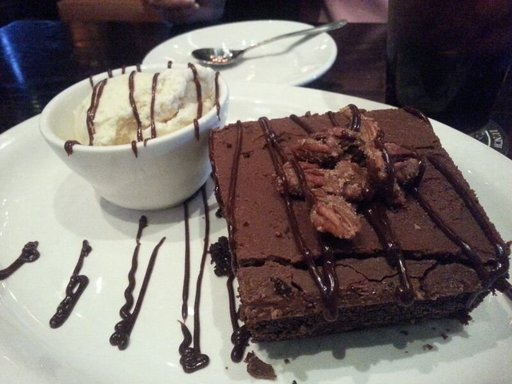

In [ ]:
import random
from PIL import Image

# Get all images path
image_path_list= list(image_path.glob("*/*/*/*.jpg"))

# Pick a random imag path
random_image_path= random.choice(image_path_list)

# Get image class from path name
image_class= random_image_path.parent.stem

# Open image
img= Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(383.5), np.float64(-0.5))

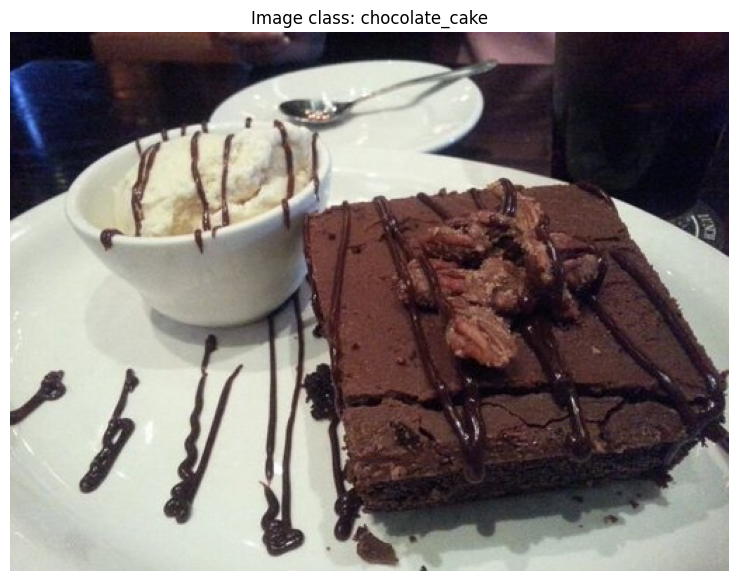

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

img_to_array= np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_to_array)
plt.title(f"Image class: {image_class}")
plt.axis(False)

**Transforming Data**

In [ ]:
import torch
from torch.utils.data import dataloader
from torchvision import datasets, transforms

In [ ]:
data_transform= transforms.Compose([
    # REsize of the image to 64*64
    transforms.Resize(size=(64,64)),
    # Flips the image randomly to horizontal side
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into torch.tensor
    transforms.ToTensor()
])

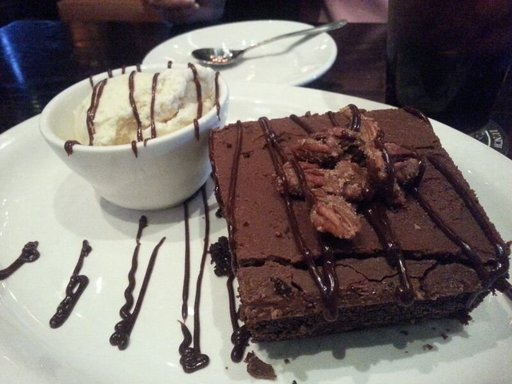

In [ ]:
img

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

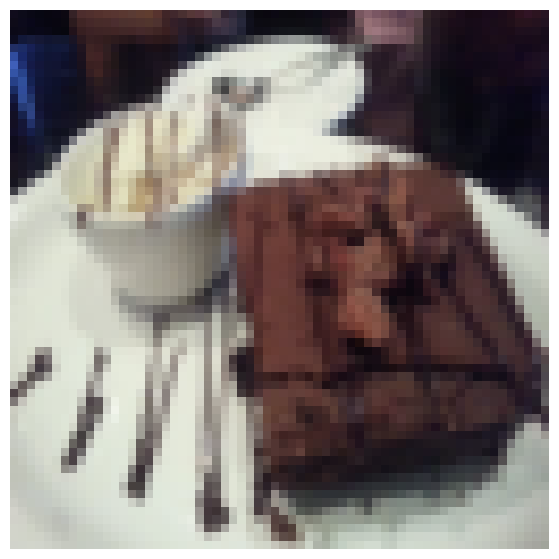

In [ ]:
plt.figure(figsize=(10, 7))
plt.imshow(data_transform(img).permute(1, 2, 0))
plt.axis(False)
plt.show()

In [ ]:
def plot_transformed_images(image_path: list, transform, n=3, seed= None):
  """
  Selects random images from a path of images and transforms them
  and then plots the original versus transform image
  """

  if seed:
    random.seed(seed)

  random_image_path= random.sample(image_path, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax= plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n size:{f.size}")
      ax[0].axis(False)

      # Transfom and plot Target images
      transformed_image= transform(f).permute(1, 2, 0)
      ax[0].imshow(transformed_image)
      ax[0].set_title(f"Transformed\n Size:{transformed_image.shape}")
      ax[0].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize= 16)


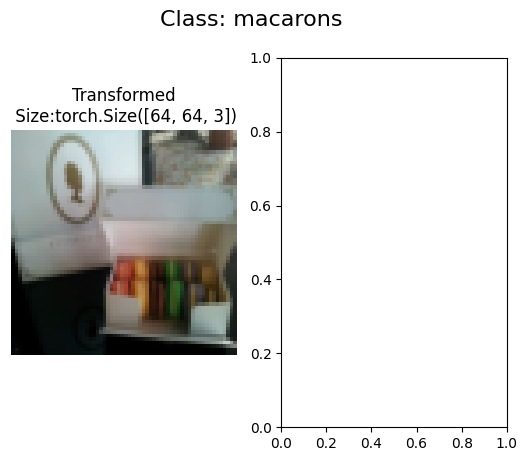

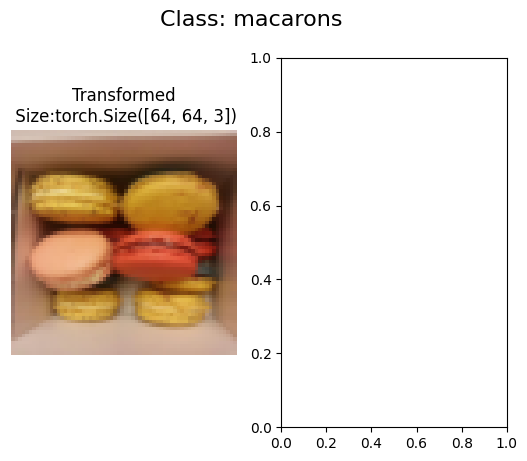

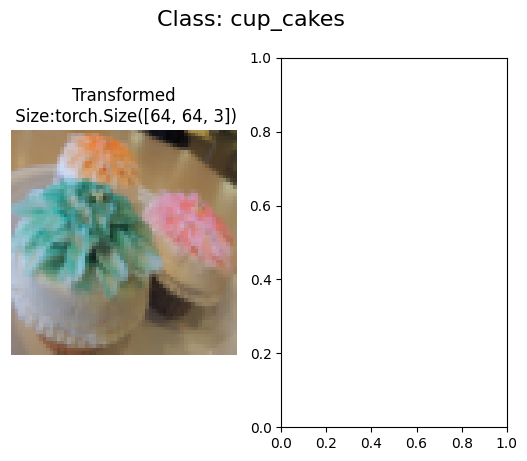

In [ ]:
plot_transformed_images(
    image_path= image_path_list,
    transform= data_transform,
    n=3,
    seed= None
)

# Loading image data using ImageFolder

In [ ]:
# Setup directories path
train_dir= image_path / "dataset/train"
test_dir= image_path / "dataset/test"

In [ ]:
# Use Imagefolder to create datasets

train_data= datasets.ImageFolder(
    root= train_dir, # Fetch images from inside folder
    transform= data_transform,
    target_transform= None
)

test_data= datasets.ImageFolder(
    root= test_dir,
    transform= data_transform,
    target_transform= None
)

In [ ]:
train_data

Dataset ImageFolder
    Number of datapoints: 1000
    Root location: data/food_images/dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
test_data

Dataset ImageFolder
    Number of datapoints: 300
    Root location: data/food_images/dataset/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [ ]:
train_data[50]

(tensor([[[0.7176, 0.5451, 0.4824,  ..., 0.2941, 0.2941, 0.3020],
          [0.5647, 0.4627, 0.4745,  ..., 0.2863, 0.2784, 0.2863],
          [0.4784, 0.4588, 0.4588,  ..., 0.2784, 0.2745, 0.2902],
          ...,
          [0.1804, 0.1686, 0.1569,  ..., 0.6078, 0.5961, 0.6039],
          [0.1725, 0.1765, 0.1569,  ..., 0.6275, 0.6157, 0.6000],
          [0.1490, 0.1569, 0.1647,  ..., 0.6392, 0.6275, 0.5961]],
 
         [[0.5020, 0.3647, 0.3176,  ..., 0.1843, 0.1804, 0.1843],
          [0.3922, 0.3059, 0.3137,  ..., 0.1765, 0.1686, 0.1765],
          [0.3255, 0.3059, 0.3098,  ..., 0.1647, 0.1647, 0.1765],
          ...,
          [0.1294, 0.1176, 0.1059,  ..., 0.5137, 0.4980, 0.4941],
          [0.1294, 0.1333, 0.1137,  ..., 0.5294, 0.5137, 0.4941],
          [0.1059, 0.1137, 0.1216,  ..., 0.5373, 0.5176, 0.4941]],
 
         [[0.3294, 0.2510, 0.2275,  ..., 0.1255, 0.1255, 0.1294],
          [0.2627, 0.2196, 0.2235,  ..., 0.1294, 0.1216, 0.1255],
          [0.2314, 0.2275, 0.2235,  ...,

In [ ]:
class_names= train_data.classes
class_names

['chocolate_cake', 'cup_cakes', 'macarons', 'sushi']

In [ ]:
class_dict= train_data.class_to_idx
class_dict

{'chocolate_cake': 0, 'cup_cakes': 1, 'macarons': 2, 'sushi': 3}

In [ ]:
len(train_data), len(test_data)

(1000, 300)

In [ ]:
image, label= train_data[0][0], train_data[0][1]

In [ ]:
image

tensor([[[0.1961, 0.4510, 0.9020,  ..., 0.9647, 0.9647, 0.9647],
         [0.3176, 0.7569, 0.9608,  ..., 0.9647, 0.9647, 0.9647],
         [0.6471, 0.9412, 0.9686,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.1098, 0.1137, 0.1098,  ..., 0.9647, 0.9647, 0.9647],
         [0.1059, 0.1059, 0.1098,  ..., 0.9647, 0.9647, 0.9647],
         [0.0980, 0.1020, 0.1176,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.1961, 0.4627, 0.9020,  ..., 1.0000, 1.0000, 1.0000],
         [0.3216, 0.7647, 0.9647,  ..., 1.0000, 1.0000, 1.0000],
         [0.6471, 0.9451, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.1020, 0.1137, 0.1176,  ..., 1.0000, 1.0000, 1.0000],
         [0.1020, 0.1020, 0.1137,  ..., 1.0000, 1.0000, 1.0000],
         [0.0941, 0.0980, 0.1176,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.2314, 0.4824, 0.8863,  ..., 0.9882, 0.9882, 0.9882],
         [0.3412, 0.7490, 0.9255,  ..., 0.9882, 0.9882, 0.9882],
         [0.6510, 0.9098, 0.9216,  ..., 0.9804, 0.9882, 0.

In [ ]:
label

0

In [ ]:
print(f"Image tensor:\n {image}")
print(f"Image shape:\n {image.shape}")
print(f"Image datatype:\n {image.dtype} ")
print(f"Image label:\n {label}")
print(f"Label datatype:\n {type(label)}")

Image tensor:
 tensor([[[0.1961, 0.4510, 0.9020,  ..., 0.9647, 0.9647, 0.9647],
         [0.3176, 0.7569, 0.9608,  ..., 0.9647, 0.9647, 0.9647],
         [0.6471, 0.9412, 0.9686,  ..., 0.9647, 0.9647, 0.9647],
         ...,
         [0.1098, 0.1137, 0.1098,  ..., 0.9647, 0.9647, 0.9647],
         [0.1059, 0.1059, 0.1098,  ..., 0.9647, 0.9647, 0.9647],
         [0.0980, 0.1020, 0.1176,  ..., 0.9647, 0.9647, 0.9647]],

        [[0.1961, 0.4627, 0.9020,  ..., 1.0000, 1.0000, 1.0000],
         [0.3216, 0.7647, 0.9647,  ..., 1.0000, 1.0000, 1.0000],
         [0.6471, 0.9451, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.1020, 0.1137, 0.1176,  ..., 1.0000, 1.0000, 1.0000],
         [0.1020, 0.1020, 0.1137,  ..., 1.0000, 1.0000, 1.0000],
         [0.0941, 0.0980, 0.1176,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.2314, 0.4824, 0.8863,  ..., 0.9882, 0.9882, 0.9882],
         [0.3412, 0.7490, 0.9255,  ..., 0.9882, 0.9882, 0.9882],
         [0.6510, 0.9098, 0.9216,  ..., 0.9

# Turn loaded images into Dataloader

In [ ]:
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader
batch_size=32

train_dataloader= DataLoader(dataset= train_data, batch_size= batch_size, num_workers= 1, shuffle= True)
test_dataloader= DataLoader(dataset= test_data, batch_size= batch_size,num_workers= 1, shuffle= False)

In [ ]:
train_dataloader

# Building a computer vision model- TinyVGG Architecture

In [ ]:
class TinyVGG(nn.Module):
  # Model architecture copying the TinyVGG from CNN explainer

  def __init__(self,
               input_shape: int,
               hidden_units:int,
               output_shape: int,
               ) -> None:

      super().__init__()
      self.conv_block_1= nn.Sequential(
          nn.Conv2d(in_channels= input_shape,
                    out_channels= hidden_units,
                    kernel_size= (3,3),
                    stride= (1,1),
                    padding= 0),
          nn.ReLU(),
          nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size= (3,3),
                    stride= (1,1),
                    padding= 0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size= (2,2),
                       stride= (2,2))
      )
      self.conv_block_2= nn.Sequential(
          nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size= 3,
                    stride= 1,
                    padding=0),
          nn.ReLU(),
          nn.Conv2d(in_channels= hidden_units,
                    out_channels= hidden_units,
                    kernel_size= 3,
                    stride= 1,
                    padding= 0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size= 2,
                       stride= 2)
      )
      self.classifier= nn.Sequential(
          nn.Flatten(),
          nn.Linear(in_features= hidden_units*13*13,
                    out_features= output_shape)
      )

  def forward(self, x):
    x= self.conv_block_1(x)
    x=self.conv_block_2(x)
    x=self.classifier(x)
    return x

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
torch.manual_seed(42)

model= TinyVGG(input_shape= 3,
               hidden_units= 10,
               output_shape= len(class_names)).to(device)

model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=4, bias=True)
  )
)

In [ ]:
# Try a dummy forward pass by passing a single image
# Get a single image batch and label batch

image_batch, label_batch= next(iter(train_dataloader))

image_batch.shape, label_batch.shape


(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
image_batch.device

device(type='cpu')

In [ ]:
logits= model(image_batch.to(device))

torch.Size([32, 10, 30, 30])
torch.Size([32, 10, 13, 13])
torch.Size([32, 4])


In [ ]:
logits

tensor([[-0.0011,  0.0209,  0.0437, -0.0150],
        [-0.0047,  0.0206,  0.0416, -0.0168],
        [-0.0032,  0.0215,  0.0431, -0.0164],
        [-0.0047,  0.0176,  0.0443, -0.0162],
        [-0.0049,  0.0232,  0.0420, -0.0163],
        [-0.0032,  0.0190,  0.0447, -0.0165],
        [-0.0053,  0.0237,  0.0443, -0.0135],
        [-0.0038,  0.0210,  0.0446, -0.0175],
        [-0.0008,  0.0169,  0.0470, -0.0123],
        [-0.0048,  0.0189,  0.0415, -0.0174],
        [ 0.0012,  0.0195,  0.0470, -0.0169],
        [-0.0048,  0.0244,  0.0448, -0.0160],
        [-0.0066,  0.0241,  0.0412, -0.0200],
        [-0.0038,  0.0216,  0.0404, -0.0207],
        [-0.0044,  0.0191,  0.0426, -0.0171],
        [-0.0033,  0.0221,  0.0449, -0.0145],
        [-0.0057,  0.0202,  0.0462, -0.0150],
        [-0.0034,  0.0220,  0.0445, -0.0150],
        [-0.0048,  0.0196,  0.0434, -0.0144],
        [-0.0050,  0.0161,  0.0444, -0.0148],
        [-0.0036,  0.0208,  0.0411, -0.0172],
        [-0.0046,  0.0191,  0.0459

In [ ]:
try:
  import torchinfo
except:
  !pip install -q torchinfo
  import torchinfo

In [ ]:
from torchinfo import summary

In [ ]:
summary(model=model,
        input_size=[1, 3, 64, 64])

torch.Size([1, 10, 30, 30])
torch.Size([1, 10, 13, 13])
torch.Size([1, 4])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 4]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### Creating a training and testing loop to train and evaluate our model

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  """
  This function will train a model on the dataloader and optimizes the model's parameters
  """

  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy value
  train_loss, train_acc= 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send data to the target device
    X, y= X.to(device), y.to(device)

    # Forward pass
    y_pred= model(X)

    # Calculate the loss
    loss= loss_fn(y_pred, y)
    train_loss += loss.item()

    # Optimizer zero grad
    optimizer.zero_grad()

    # Apply backpropagation algo
    loss.backward()

    # Optimizer step (Gradient desecent algo)
    optimizer.step()

    # Calculate accuracy
    y_pred_class= torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

 # Adjust metrics to get average loss and accuracy per batch
  train_loss= train_loss / len(dataloader)
  train_acc= train_acc / len(dataloader)
  return train_loss, train_acc


In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  """
  This function will test a model on the dataloader and optimizes the model
  """

  # Put model in Evaluation mode
  model.eval()

  test_loss, test_acc= 0, 0

  # Turn on inference mode
  with torch.inference_mode():

    # Loop through DataLOader batches
    for batch, (X,y) in enumerate(dataloader):

      X, y= X.to(device), y.to(device)

      # Forwrd pass
      y_pred= model(X)

      # Calculate the loss
      loss= loss_fn(y_pred, y)
      test_loss += loss.item()

      # Calculate the accuracy
      y_pred_labels= y_pred.argmax(dim= 1)
      test_acc += (y_pred_labels == y).sum().item()/len(y_pred_labels)

   # Adjust metrics to get average loss and accuracy per batch
    test_loss= test_loss/ len(dataloader)
    test_acc= test_acc/ len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm
# Combine train_step and test_step both and calls them toghether in one hit


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.dataloader,
          test_dataloader: torch.utils.data.dataloader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module= nn.CrossEntropyLoss(),
          epochs: int= 50,
          device= device):

     results={"train_loss": [],
           "train_acc": [],
           "test_loss": [],
           "test_acc": []}
     # Loop through training and testing steps for number of epochs
     for epoch in tqdm(range(epochs)):

        train_loss, train_acc= train_step(model= model,
                                          dataloader= train_dataloader,
                                          loss_fn= loss_fn,
                                          optimizer= optimizer,
                                          device= device)
        test_loss, test_acc= test_step(model= model,
                                       dataloader= test_dataloader,
                                       loss_fn= loss_fn,
                                       device= device)

        print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train accuracy: {train_acc:.3f} | Test loss: {test_loss:.3f} | Test accuracy: {test_acc:.3f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

     return results

In [ ]:
# Set random seeds

torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS= 50

# Recreating instance of TinyVGG
model= TinyVGG(input_shape=3,
               hidden_units=32,
               output_shape= len(class_names)).to(device)

# Setup loss function and optimizer
loss_fn= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(params= model.parameters(),
                            lr= 0.001)

# Start the timer
from timeit import default_timer as timer
start_time= timer()

model_results= train(model= model,
                     train_dataloader= train_dataloader,
                     test_dataloader= test_dataloader,
                     optimizer= optimizer,
                     loss_fn= loss_fn,
                     epochs= NUM_EPOCHS)

# End the timer
end_time= timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.375 | Train accuracy: 0.271 | Test loss: 1.307 | Test accuracy: 0.394
Epoch: 1 | Train loss: 1.255 | Train accuracy: 0.425 | Test loss: 1.255 | Test accuracy: 0.404
Epoch: 2 | Train loss: 1.191 | Train accuracy: 0.462 | Test loss: 1.238 | Test accuracy: 0.392
Epoch: 3 | Train loss: 1.170 | Train accuracy: 0.468 | Test loss: 1.223 | Test accuracy: 0.431
Epoch: 4 | Train loss: 1.157 | Train accuracy: 0.472 | Test loss: 1.205 | Test accuracy: 0.471
Epoch: 5 | Train loss: 1.144 | Train accuracy: 0.492 | Test loss: 1.268 | Test accuracy: 0.475
Epoch: 6 | Train loss: 1.124 | Train accuracy: 0.494 | Test loss: 1.219 | Test accuracy: 0.444
Epoch: 7 | Train loss: 1.117 | Train accuracy: 0.508 | Test loss: 1.295 | Test accuracy: 0.427
Epoch: 8 | Train loss: 1.092 | Train accuracy: 0.527 | Test loss: 1.203 | Test accuracy: 0.472
Epoch: 9 | Train loss: 1.084 | Train accuracy: 0.521 | Test loss: 1.298 | Test accuracy: 0.410
Epoch: 10 | Train loss: 1.033 | Train accuracy: 0.